In [1]:
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer

# train test split and cross validation
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC

In [2]:
sms_df = pd.read_csv("spam.csv", encoding="latin-1")
sms_df = sms_df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
sms_df = sms_df.rename(columns={"v1": "target", "v2": "sms"})

In [3]:
train_df, test_df = train_test_split(sms_df, test_size = 0.2, random_state = 123)

X_train = train_df["sms"]
y_train = train_df["target"]
X_test = test_df["sms"]
y_test = test_df["target"]

In [4]:
train_df.target.value_counts()

ham     3843
spam     614
Name: target, dtype: int64

>ham and spam are the labels, with 3843 ham and 614 spam

In [5]:
train_df.sms.str.len().mean()

80.28427193179269

In [6]:
train_df.sms.str.len().argmin(), train_df.sms.str.len().argmax()
train_df.iloc[1401], train_df.iloc[3608]

(target    ham
 sms        Ok
 Name: 5357, dtype: object,
 target                                                  ham
 sms       The last thing i ever wanted to do was hurt yo...
 Name: 1862, dtype: object)

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [8]:
spam = train_df.query('target=="spam"').sms.str.cat(sep=',')
ham = train_df.query('target=="ham"').sms.str.cat(sep=',')

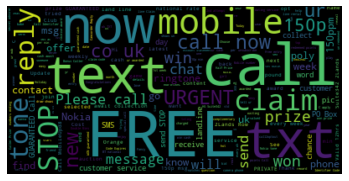

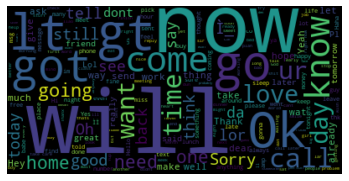

In [9]:
wc_image = WordCloud().generate(spam)
plt.imshow(wc_image, interpolation='bilinear')
plt.axis("off")
plt.show()

wc_image = WordCloud().generate(ham)
plt.imshow(wc_image, interpolation='bilinear')
plt.axis("off")
plt.show()

##  Preprocessing 

In [10]:
vec = CountVectorizer()
X_counts = vec.fit_transform(train_df.sms)

X_counts.shape

(4457, 7682)

> 7682 features represents the text messages, and each feature = unique word in vocab. 

In [11]:
vec_binary = CountVectorizer(binary=True)
X_counts_binary = vec_binary.fit_transform(train_df.sms)
X_counts_binary.shape

(4457, 7682)

> Each feature represented is a T or F in the DF, because of binary=True 

In [12]:
vec10_binary = CountVectorizer(binary=True, max_features=10)
X_counts_binary = vec10_binary.fit_transform(train_df.sms)
X_counts_binary.shape

(4457, 10)

## Model building 
<hr>

In [13]:
pipe_3_1 = make_pipeline(CountVectorizer(binary=True), DummyClassifier(strategy="most_frequent"))
scores_3_1 = cross_validate(pipe_3_1, X_train, y_train, cv=5, return_train_score=True)
pd.DataFrame(scores_3_1).mean()

fit_time       0.076190
score_time     0.016586
test_score     0.862239
train_score    0.862239
dtype: float64

### `SVC` with default parameters

In [14]:
# pipe_3_2 = make_pipeline(CountVectorizer(binary=True), SVC())
pipe_3_2 = Pipeline([('pca', CountVectorizer(binary=True)), ('clf', SVC())])

scores_3_2 = cross_validate(pipe_3_2, X_train, y_train, cv=5, return_train_score=True)
pd.DataFrame(scores_3_2).mean()

fit_time       0.682063
score_time     0.158482
test_score     0.979133
train_score    0.995961
dtype: float64

In [15]:
# pipe_3_2.get_params().keys()

## Hyperparameter optimization

In [16]:
param_grid = {"clf__gamma": 10.0 ** np.arange(-3, 3)}

In [17]:
gamma_4_1 = GridSearchCV(pipe_3_2, param_grid, cv=10, n_jobs=-1, return_train_score=True)
gamma_4_1.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('pca', CountVectorizer(binary=True)),
                                       ('clf', SVC())]),
             n_jobs=-1,
             param_grid={'clf__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             return_train_score=True)

In [18]:
print("Best cv score from grid search: %.3f" % gamma_4_1.best_score_)
gamma_4_1.best_params_

Best cv score from grid search: 0.977


{'clf__gamma': 0.01}

In [19]:
scores_df = pd.DataFrame(gamma_4_1.cv_results_).set_index("rank_test_score").sort_index()
# scores_df
scores_df.filter(items=['mean_fit_time', 'param_clf__gamma', 'mean_train_score', 'mean_test_score'])

,mean_fit_time,param_clf__gamma,mean_train_score,mean_test_score
rank_test_score,,,,
1,1.025542,0.01,0.984494,0.976666
2,1.715499,0.1,0.997333,0.975544
3,1.266196,0.001,0.899060,0.893875
4,3.062281,1,0.999776,0.893427
5,3.017943,10,1.000000,0.892754
5,4.229174,100,1.000000,0.892754


>.979 from previous q, compared to .977 from gamma 0.01. This one is better by a little bit, but they are very simliar. 

### Optimizing `C` and `gamma` 

In [20]:
param_grid_4_2 = {"clf__gamma": 10.0 ** np.arange(-3, 3),
             "clf__C": 10.0 ** np.arange(-3, 3)}

gamma_4_2 = GridSearchCV(pipe_3_2, param_grid_4_2, cv=10, n_jobs=-1, return_train_score=True)
gamma_4_2.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('pca', CountVectorizer(binary=True)),
                                       ('clf', SVC())]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'clf__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             return_train_score=True)

In [21]:
print("Best cv score from grid search: %.3f" % gamma_4_2.best_score_)
gamma_4_2.best_params_

Best cv score from grid search: 0.985


{'clf__C': 100.0, 'clf__gamma': 0.001}

> I didn't get the same gamma value!! This one is 0.001, instead of 0.01. This is because I optimzed 2 hyperparameters in this step. The 2 hyperparameters affected each other during the CV, creating a better cv score.

### Optimizing `C`, `gamma`, and `max_features` jointly with `RandomizedSearchCV`

In [22]:
param_grid_random = {"clf__gamma": 10.0 ** np.arange(-3, 3),
             "clf__C": 10.0 ** np.arange(-3, 3),
                 "pca__max_features": [100,200]}

random_searching = RandomizedSearchCV(pipe_3_2, 
                                      param_distributions=param_grid_random, 
                                      n_jobs=-1, n_iter=10, return_train_score=True, cv=10)
random_searching.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('pca',
                                              CountVectorizer(binary=True)),
                                             ('clf', SVC())]),
                   n_jobs=-1,
                   param_distributions={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                        'clf__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                        'pca__max_features': [100, 200]},
                   return_train_score=True)

In [23]:
print("Best cv score from grid search: %.3f" % random_searching.best_score_)
random_searching.best_params_

Best cv score from grid search: 0.973


{'pca__max_features': 200, 'clf__gamma': 0.001, 'clf__C': 100.0}

> We would prefer randomsearch over grid search if there are some paramters that are more important than others. Since we don't know in advance which hyperparamters are important for the problem, this will help us figure that out as well. 

## Test results 

In [24]:
final_est = random_searching.best_estimator_
final_est.fit(X_train, y_train)

Pipeline(steps=[('pca', CountVectorizer(binary=True, max_features=200)),
                ('clf', SVC(C=100.0, gamma=0.001))])

In [25]:
final_est.score(X_test, y_test)

0.9766816143497757

> So, it looks like using the RandomSearchCV on the test data has a score of .98, which is very simliar to the previous estimators. This is good and consitent with the previous training/validation scores!!